In [1]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
import PyKDL as kdl
import kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb


In [2]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 


def g_kdl_func():
    for j in range(njoints):
        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    kdl.ChainDynParam(kdlmodel, gravity_kdl).JntToGravity(q_kdl, g_kdl)


def g_u2c_func():   
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    g_u2c(q_none)
    
def g_pb_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    g_pb = pb.calculateInverseDynamics(pbmodel, q_none, qdot, qddot)
    
def g_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.InverseDynamics(rbdlmodel, q_np, qdot_np, qddot_np, g_rbdl)



In [17]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 60
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data
mediantime_kdl = [None]*ndofs
mediantime_u2c = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_pb = [None]*ndofs
mintime_kdl = [None]*ndofs
mintime_u2c = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_pb = [None]*ndofs
averagetime_kdl = [None]*ndofs
averagetime_u2c = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_pb = [None]*ndofs

nitr = 10
nrepeat = 100
    
for i in range(ndofs):    
    path_to_urdf = "/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    root = 'base_link'
    tip = "link" + str(urdf_nr[i])
    #path_to_urdf = str(urdf_nr[i]) + "dof.urdf"

    
    ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True, flags = pb.URDF_USE_INERTIA_FROM_FILE)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = asd.get_n_joints(root, tip)

    gravity_kdl = kdl.Vector()
    gravity_kdl[2] = -9.81
    gravity_u2c = [0, 0, -9.81]
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    g_rbdl = np.zeros(njoints)
    
    #kdl declatations
    q_kdl = kdl.JntArray(njoints)
    g_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    g_pb = [None]*njoints
    
    qddot = []
    for i in range(njoints):
        qddot.append(0.)
        
    qdot = []
    for i in range(njoints):
        qdot.append(0.)
        
    g_u2c = asd.get_gravity_rnea(root, tip, gravity_u2c)
    timeit_u2c = repeat("g_u2c_func()", setup = "from __main__ import g_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c[i] = min(timeit_u2c)/nitr*1000000
    mediantime_u2c[i] = median(timeit_u2c)/nitr*1000000
    averagetime_u2c[i] = average(timeit_u2c)/nitr*1000000
    
    #timeit_pb = repeat("g_pb_func()", setup = "from __main__ import g_pb_func", repeat = nrepeat, number = nitr)
    #mintime_pb[i] = min(timeit_pb)/nitr*1000000
    #mediantime_pb[i] = median(timeit_pb)/nitr*1000000
    #averagetime_pb[i] = average(timeit_pb)/nitr*1000000
    
    #timeit_rbdl = repeat("g_rbdl_func()", setup = "from __main__ import g_rbdl_func", repeat = nrepeat, number = nitr)
    #mintime_rbdl[i] = min(timeit_rbdl)/nitr*1000000
    #mediantime_rbdl[i] = median(timeit_rbdl)/nitr*1000000
    #averagetime_rbdl[i] = average(timeit_rbdl)/nitr*1000000
    
    #timeit_kdl = repeat("g_kdl_func()", setup = "from __main__ import g_kdl_func", repeat = nrepeat, number = nitr)
    #mintime_kdl[i] = min(timeit_kdl)/nitr*1000000
    #mediantime_kdl[i] = median(timeit_kdl)/nitr*1000000
    #averagetime_kdl[i] = average(timeit_kdl)/nitr*1000000
    



The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/1dof.urdf
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/2dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/3dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/4dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2

The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/36dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/37dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/38dof.urdf
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/39dof.urdf
The root link ba

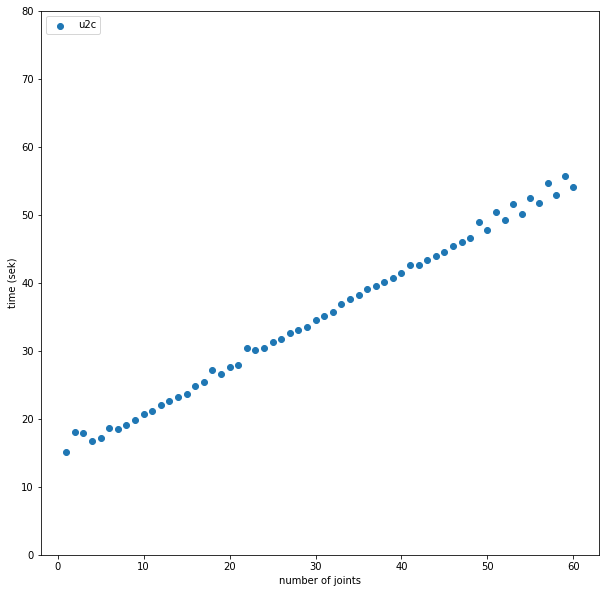

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (10, 10))
plt.scatter(joint_nr, mintime_u2c, label='u2c')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.ylim(0, 80)
plt.legend(loc='upper left')
med_fig.show()



In [16]:
print mintime_u2c

[15.187263488769531, 16.498565673828125, 17.595291137695312, 16.78466796875, 17.499923706054688, 17.881393432617188, 18.405914306640625, 18.906593322753906, 19.788742065429688, 20.48015594482422, 22.19676971435547, 22.077560424804688, 22.31597900390625, 23.508071899414062, 23.889541625976562, 24.700164794921875, 25.48694610595703, 26.702880859375, 26.82209014892578, 27.608871459960938, 28.204917907714844, 29.993057250976562, 30.088424682617188, 30.39836883544922, 31.113624572753906, 31.900405883789066, 32.401084899902344, 33.092498779296875, 33.99848937988281, 34.499168395996094, 35.59589385986328, 35.90583801269531, 36.81182861328125, 37.90855407714844, 38.09928894042969, 42.48619079589844, 39.696693420410156, 39.79206085205078, 40.793418884277344, 41.294097900390625, 41.985511779785156, 42.29545593261719, 43.29681396484375, 43.892860412597656, 44.417381286621094, 45.299530029296875, 45.70484161376953, 46.80156707763672, 47.087669372558594, 47.397613525390625, 48.30360412597656, 49.18

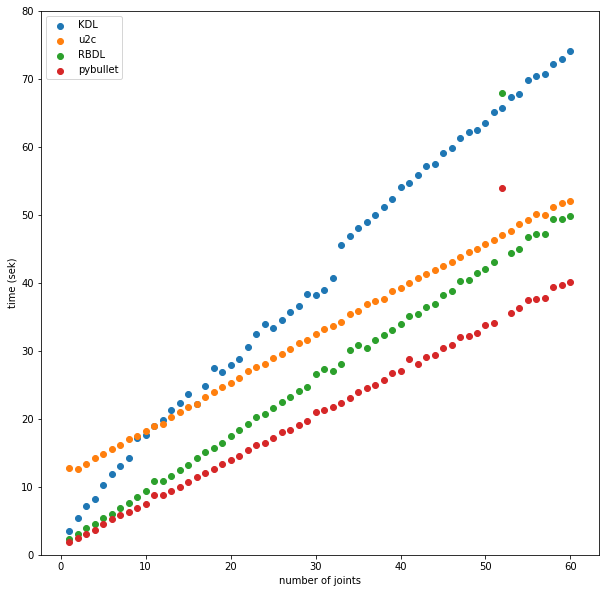

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (10, 10))
plt.scatter(joint_nr, mediantime_kdl, label='KDL')
#plt.scatter(joint_nr, mediantime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, mintime_u2c, label='u2c')
plt.scatter(joint_nr, mediantime_rbdl, label='RBDL')
plt.scatter(joint_nr, mediantime_pb, label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.ylim(0, 80)
plt.legend(loc='upper left')
med_fig.show()



[Text(0,0,'pybullet'), Text(0,0,'RBDL'), Text(0,0,'U2C'), Text(0,0,'KDL')]

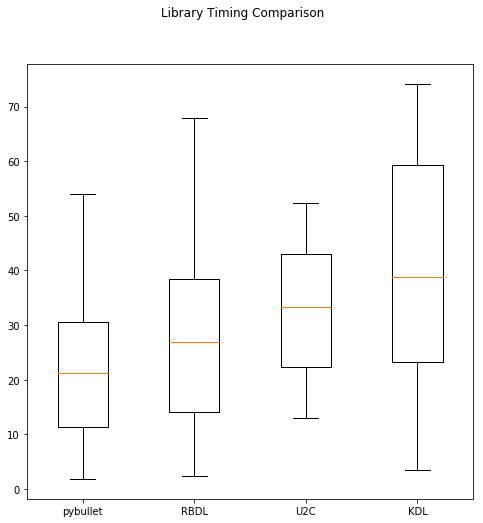

In [8]:
timing_scores = [mediantime_pb, mediantime_rbdl, mediantime_u2c, mediantime_kdl]
names = ["pybullet", "RBDL", "U2C", "KDL"]#, "RBDL", "pybullet"]
boxplot = plt.figure(figsize = (8, 8))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)


In [7]:
print "mediantime_u2c = ", averagetime_u2c

print "mediantime_kdl = ", averagetime_kdl

print "mediantime_rbdl = ", averagetime_rbdl

print "mediantime_pb = ", averagetime_pb

mediantime_u2c =  [0.005529472827911377, 0.006809735298156738, 0.007175900936126709, 0.0077907776832580565, 0.00829638957977295, 0.008940403461456298, 0.009464142322540283, 0.009849491119384766, 0.010562646389007568, 0.01095331907272339, 0.011550712585449218, 0.01205876111984253, 0.012691278457641602, 0.01276979684829712, 0.013765852451324462, 0.014242343902587891, 0.014812791347503662, 0.01520984411239624, 0.015697948932647705, 0.01641841173171997, 0.017267060279846192, 0.018248791694641112, 0.018168148994445802, 0.019169392585754393, 0.019362385272979735, 0.020118632316589356, 0.021027424335479737, 0.020604279041290283, 0.02177851438522339, 0.021955745220184328, 0.023315625190734865, 0.0233111310005188, 0.024440312385559083, 0.024415969848632812, 0.025214636325836183, 0.02566841125488281, 0.026883277893066406, 0.02690901517868042, 0.028317630290985107, 0.02758955955505371, 0.029367387294769287, 0.029562668800354006, 0.030113325119018555, 0.030049929618835448, 0.031397907733917235, 0.